In [1]:
import pickle
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import os
from collections import defaultdict
import re
import json
from collections import Counter
import dateutil
from dateutil import parser
from collections import defaultdict
from __future__ import division
import datetime
%pylab inline
from numpy import arange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
def parseint(string):
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [7]:
with open('movie_info_revised.p' ,'r') as picklefile:
    data = pickle.load(picklefile)

In [8]:
def date_helper(date):
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [32]:
history_keys_dic = defaultdict(dict)
for key in data.keys():
    if 'War' in data[key]['genre'] and 'Comedy' not in data[key]['genre']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_keys_dic['count'][year]= history_keys_dic['count'].get(year, 0) + 1  
history_df = pd.DataFrame.from_dict(history_keys_dic)
start = pd.datetime(1980, 1, 1)
end = pd.datetime(2016, 1, 1)
x = pd.date_range(start, end, freq='A').year
history_df_years = history_df.reindex(x)
history_df = history_df_years.fillna(0)
history_df['rolling mean']=pd.rolling_mean(history_df['count'], 5).shift(+1)
history_df['difference from mean']=history_df['count']/history_df['rolling mean']

In [33]:
history_keys_dic

defaultdict(<type 'dict'>, {'count': {1973: 1, 1975: 1, 1976: 3, 1977: 4, 1978: 5, 1979: 2, 1980: 3, 1981: 2, 1982: 3, 1983: 2, 1984: 3, 1985: 2, 1986: 3, 1987: 4, 1988: 5, 1989: 3, 1990: 5, 1991: 1, 1992: 2, 1993: 1, 1995: 3, 1996: 3, 1997: 4, 1998: 3, 1999: 3, 2000: 3, 2001: 4, 2002: 8, 2003: 3, 2004: 2, 2005: 3, 2006: 3, 2007: 9, 2008: 7, 2009: 5, 2010: 2, 2011: 3, 2012: 4, 2013: 1, 2015: 3}})

In [34]:
history_df

,count,rolling mean,difference from mean
1980,3,NaN,NaN
1981,2,NaN,NaN
1982,3,NaN,NaN
1983,2,NaN,NaN
1984,3,NaN,NaN
1985,2,2.6,0.769231
1986,3,2.4,1.250000
1987,4,2.6,1.538462
1988,5,2.8,1.785714
1989,3,3.4,0.882353


In [28]:
history_dic = defaultdict(dict)
for key in data.keys():
    if 'War' in data[key]['genre'] and 'Comedy' not in data[key]['genre']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_dic[year][key]= defaultdict(dict)
            history_dic[year][key]['date']= data[key]['date']
            history_dic[year][key]['screens']= data[key]['screens']
            history_dic[year][key]['opening']= data[key]['opening']
                #space_dic['space'][year].append(key,)

In [29]:
history_dic

defaultdict(<type 'dict'>, {1973: {'Massacre in Rome': defaultdict(<type 'dict'>, {'date': '24 October 1973', 'screens': 'Error', 'opening': 'N/A'})}, 1975: {'The Old Gun': defaultdict(<type 'dict'>, {'date': '22 August 1975', 'screens': 'Error', 'opening': 'N/A'})}, 1976: {'Voyage of the Damned': defaultdict(<type 'dict'>, {'date': '22 December 1976', 'screens': 'n/a', 'opening': 'n/a'}), 'General Idi Amin Dada': defaultdict(<type 'dict'>, {'date': '30 August 1976', 'screens': 'Error', 'opening': 'N/A'}), 'Operation: Daybreak': defaultdict(<type 'dict'>, {'date': '27 February 1976', 'screens': 'Error', 'opening': 'N/A'})}, 1977: {'Cross of Iron': defaultdict(<type 'dict'>, {'date': '8 March 1977', 'screens': 'Error', 'opening': 'N/A'}), 'The Hiding Place': defaultdict(<type 'dict'>, {'date': '15 February 1977', 'screens': 'Error', 'opening': 'N/A'}), 'A Bridge Too Far': defaultdict(<type 'dict'>, {'date': '15 June 1977', 'screens': 'n/a', 'opening': 'n/a'}), 'March or Die': defaultdic

In [30]:
def makedf(genre):
    frames = []
    years = []
    for year, movies in genre.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    genre['normalized_opening']= genre['opening']/genre['screens']
    genre = genre[genre.normalized_opening < 20000]
    return genre

In [31]:
genre=makedf(history_dic)
pd.set_option('display.max_rows', 1000)
genre1 = genre[genre.screens > 50]
genre1 = genre1.reset_index()
genre1

,level_0,level_1,date,screens,opening,normalized_opening
0,1982,Inchon,1982-09-17,1291,2326112,1801.790860
1,1982,Monsignor,1982-10-22,857,3631834,4237.845974
2,1983,Under Fire,1983-10-21,816,1837768,2252.166667
3,1984,Red Dawn,1984-08-10,1822,8230381,4517.223381
4,1984,The Razor's Edge,1984-10-19,1036,2411311,2327.520270
5,1986,Iron Eagle,1986-01-17,1080,6104754,5652.550000
6,1986,Sky Bandits,1986-10-31,1335,1468500,1100.000000
7,1987,Empire of the Sun,1987-12-25,225,1314509,5842.262222
8,1987,Full Metal Jacket,1987-07-10,215,2217307,10313.055814
9,1987,Gardens of Stone,1987-05-08,612,1645588,2688.869281


In [23]:
trend = genre1[25:42]

trend

,level_0,level_1,date,screens,opening,normalized_opening
25,1999,The Thin Red Line,1999-01-15,1528,11362226,7436.011780
26,2000,Rules of Engagement,2000-04-07,3155,15011181,4757.902060
27,2000,U-571,2000-04-21,2583,19553310,7570.000000
28,2001,Behind Enemy Lines,2001-11-30,2770,18736133,6763.946931
29,2002,Harrison's Flowers,2002-03-15,398,867635,2179.987437
30,2002,Hart's War,2002-02-15,2459,7771753,3160.533957
31,2002,Windtalkers,2002-06-14,2898,14520412,5010.494134
32,2003,Gods and Generals,2003-02-21,1533,4675246,3049.736464
33,2003,The Pianist,2003-03-28,773,2456117,3177.382924
34,2004,The Alamo,2004-04-09,2609,9124701,3497.394021


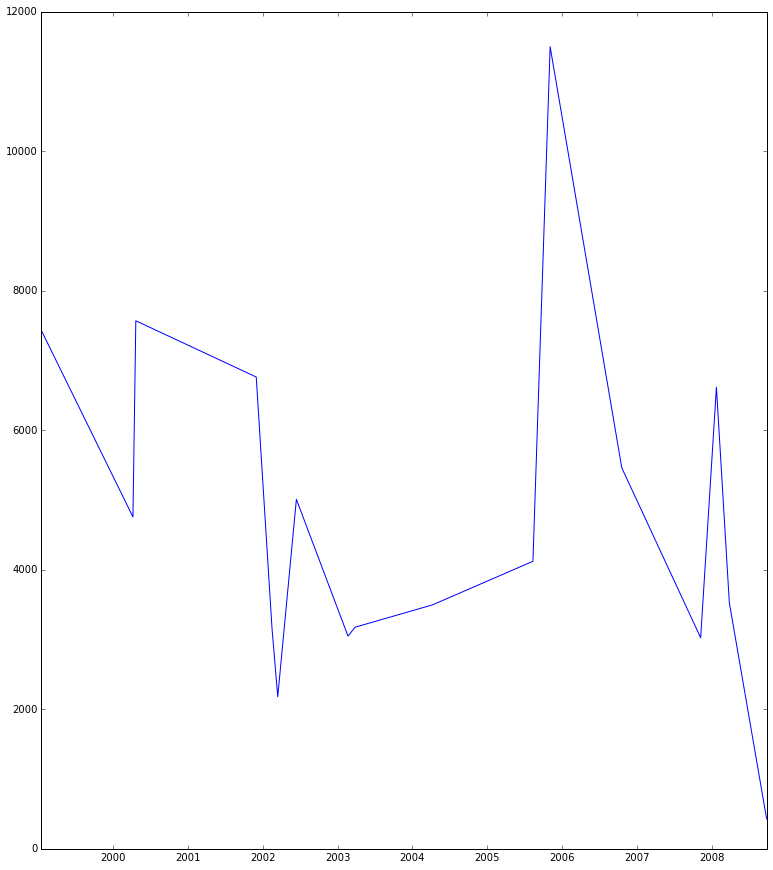

In [24]:
figure(figsize=(13,15))
trend = trend.sort(['date'])
plt.plot(trend['date'], trend['normalized_opening'])

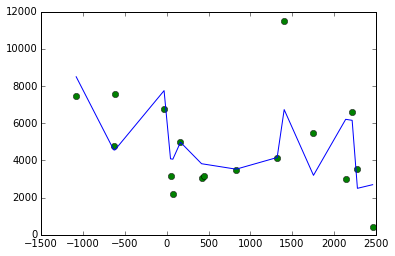

In [25]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('2002-01-01')))
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

def sort_season(x):
    if x in [11, 12, 1]:
        return 'Winter'
    if x in [5, 6, 7, 8]:
        return 'Summer'
    if x in [9, 10,]:
        return 'Fall'
    if x in [2, 3, 4,]:
        return 'Spring'

trend['season']=trend['date'].apply(lambda x: sort_season(x.month))
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season ', data = trend, return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')



In [26]:
model.fit().summary()

/Users/David/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     normalized_opening   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     2.331
Date:                Thu, 08 Oct 2015   Prob (F-statistic):              0.115
Time:                        18:30:27   Log-Likelihood:                -152.41
No. Observations:                  17   AIC:                             314.8
Df Residuals:                      12   BIC:                             319.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         4442.4904   2004.832      2.216      0.047        74.338  8810.643
season[T.Spring]  -325.3066   2049.138     -0.159      0.877     -4789.994  4139.381
season[T.Summer]   650.5882   2388.262      0.272      0.790     -4552.988  5854.164
season[T.Winter]  3285.6535   2005.123      1.639      0.127     -1083.134  7654.441
time_delta_num      -0.7104      0.577     -1.231      0.242        -1.968     0.547
==============================================================================
Omnibus:                        4.109   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                2.086
Skew:                           0.817   Prob(JB):                        0.352
Kurtosis:                       3.526   Cond. No.                     9.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
trend = trend.reset_index()
with open('war.p', 'w') as picklefile:
    pickle.dump(trend, picklefile)